In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

In [3]:
INPUT_FILE = 'twitter-airline-sentiment/Tweets.csv'
MODEL_PATH = 'data/model2'

from nltk.tokenize.casual import TweetTokenizer

REGEX_URL = re.compile(r'https?://|www.')
TOKEN_URL = 'xxurl'
TOKEN_HANDLE = 'xxhan'

def normalize_token(token):
    if token.startswith('@'):
        return TOKEN_HANDLE
    elif token.startswith('#') and token[1:].isalpha():
        return token[1:]
    elif re.match(REGEX_URL, token):
        return TOKEN_URL
    else:
        return token    

tokenizer = TweetTokenizer(preserve_case=True)

def normalize_text(text):
    tokens = tokenizer.tokenize(text)
    
    # if the first token is a handler, it's normally irrelevant
    if tokens[0].startswith('@'):
        tokens.pop(0)
    
    return ' '.join(normalize_token(t) for t in tokens)


raw_data = pd.read_csv(INPUT_FILE, header=0)
df = raw_data.copy()[['text', 'airline_sentiment']]
df = df.rename(columns={'airline_sentiment': 'sentiment'})
df_raw = df.copy()

df['text'] = df['text'].apply(normalize_text)
df_labeled = df[df.sentiment != 'neutral']

print("DATA SIZE: " + str(df.shape))
df.head()

DATA SIZE: (14640, 2)


,text,sentiment
0,What xxhan said .,neutral
1,plus you've added commercials to the experienc...,positive
2,I didn't today ... Must mean I need to take an...,neutral
3,"it's really aggressive to blast obnoxious "" en...",negative
4,and it's a really big bad thing about it,negative


In [4]:
def show_normalization(_df):
    for i, row in _df.iterrows():
        print(row.sentiment.upper() + ": " + row.text + '\n>> ' + normalize_text(row.text) + '\n')

show_normalization(df_raw.head(30))

NEUTRAL: @VirginAmerica What @dhepburn said.
>> What xxhan said .

POSITIVE: @VirginAmerica plus you've added commercials to the experience... tacky.
>> plus you've added commercials to the experience ... tacky .

NEUTRAL: @VirginAmerica I didn't today... Must mean I need to take another trip!
>> I didn't today ... Must mean I need to take another trip !

NEGATIVE: @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
>> it's really aggressive to blast obnoxious " entertainment " in your guests ' faces & they have little recourse

NEGATIVE: @VirginAmerica and it's a really big bad thing about it
>> and it's a really big bad thing about it

NEGATIVE: @VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA
>> seriously would pay $ 30 a flight for seats that didn't have this playing . it's really the only bad thing about flying VA

POSITI

In [5]:
# creating the data source
bs = 48

data_lm = (TextList.from_df(df, cols=['text'])
           .split_by_rand_pct(valid_pct=0.1, seed=0)
           .label_for_lm()
           .databunch(bs=bs))

In [6]:
data_lm.show_batch()

idx,text
0,"$ 30 a flight for seats that did n't have this playing . it 's really the only bad thing about flying xxup va xxbos yes , nearly every time i fly xxup vx this “ xxunk xxunk ” won ’ t go away :) xxbos xxmaj really missed a prime opportunity for xxmaj men xxmaj without xxmaj hats xxunk , there . xxurl xxbos xxmaj well , i did"
1,"xxbos to jump into the xxmaj dallas xxmaj austin market xxurl xxbos i spoke with a representative that offered no solution , i am a loyal customer who flies on xxhan as well xxbos i am xxunk disappointed that your birthday promo was not applied to a trip i booked xxunk days before i received the email xxbos what happened to direct flights from xxup sfo - xxup fll ?"
2,of communication :( xxbos checking to see why flight xxunk ( atl - ord ) got xxmaj cancelled xxmaj flighted ? xxbos service so far has been horrid . xxmaj we wanted to end the trip on a high note . xxmaj guess that 's not an option . xxbos xxmaj booked a flight home over 7 months ago and requested seats together for my xxunk and i . xxmaj
3,xxbos will not have to honor xxunk low mistake fares . xxurl xxunk xxhan xxbos xxunk delayed departure to check bags at gate claiming space filled and walk on to open xxunk a delay poorcustomerservice xxbos you xxmaj cancelled xxmaj flighted our flights for no reason & now we have been on the phone for xxup an xxup hour on our vacation . xxmaj why ? xxbos xxhan xxup that
4,"flight my flight . i wait in line to get rebooked , when i 'm at the front you make me go to another gate and i lose my place . xxbos it was n't a comment . xxmaj it was a question . xxmaj but thanks for your copy and paste response xxbos you failed me last week at xxup iah . xxmaj next intl trip on xxmaj delta"


In [7]:
data_lm

TextLMDataBunch;

Train: LabelList (13176 items)
x: LMTextList
xxbos xxmaj what xxhan said .,xxbos plus you 've added commercials to the experience ... xxunk .,xxbos i did n't today ... xxmaj must mean i need to take another trip !,xxbos it 's really aggressive to xxunk xxunk " entertainment " in your guests ' xxunk & they have little recourse,xxbos and it 's a really big bad thing about it
y: LMLabelList
,,,,
Path: .;

Valid: LabelList (1464 items)
x: LMTextList
xxbos xxmaj in car xxunk to xxup dfw . xxmaj pulled over 1hr ago - very icy roads . xxmaj on - hold with xxup aa since 1hr . xxmaj ca n't reach xxunk for xxup xxunk . xxmaj xxunk 2 do ?,xxbos after all , the plane didn ’ t land in xxunk or worse ) conditions at xxup grk according to xxunk .,xxbos ca n't believe how many paying customers you left high and xxunk with no reason for flight xxmaj cancelled xxmaj flightlations xxmaj monday out of xxup bdl ! xxmaj wow .,xxbos i can xxunk say that i would have rather driven cross coun

In [8]:
data_lm.save('lm_raw01.pkl')

In [9]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [10]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.31E-02
Min loss divided by 10: 4.37E-02


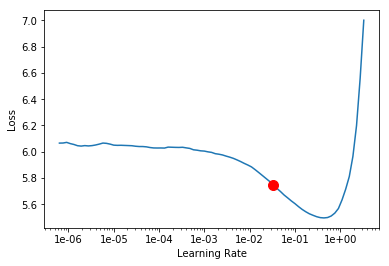

In [11]:
learn.recorder.plot(suggestion=True)

In [12]:
learn.fit_one_cycle(1, 3e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.343898,3.991462,0.250714,00:12


In [13]:
learn.save('fit_head')

In [14]:
learn.load('fit_head');

In [15]:
learn.unfreeze()

In [16]:
learn.fit_one_cycle(10, 3e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.782333,3.845161,0.274464,00:17
1,3.683698,3.853061,0.263304,00:17
2,3.471895,3.781385,0.283304,00:17
3,3.117830,3.846267,0.279107,00:17
4,2.645753,4.001273,0.276518,00:17
5,2.132520,4.200161,0.274851,00:17
6,1.659791,4.400119,0.272857,00:17
7,1.332116,4.545593,0.268690,00:17
8,1.116226,4.602796,0.267649,00:17
9,1.016920,4.625179,0.267887,00:17


In [17]:
learn.save('fine_tuned')

In [18]:
learn.load('fine_tuned');

In [19]:
TEXT = "My flight was"
N_WORDS = 40
N_SENTENCES = 2

In [20]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

My flight was Cancelled Flightled and i 'm being reimbursed for hotel and taxis for my Cancelled Flightled flight . You suck but i 've been on hold for more than a hour . xxbos ARE
My flight was delayed for 3 hours bc of checked bag , and it has been almost 24 hours and still no call ... xxbos i dm'd you xxbos you need to follow me i order for me to DM ... xxbos


In [21]:
learn.save_encoder('fine_tuned_enc')

### Classifier

In [22]:
def balance_class_counts(df):
    class_counts = df.groupby('sentiment').count()
    min_size = class_counts['text'].min()
    classes = []
    for label in class_counts.index:
        classes.append(df.copy()[df.sentiment == label][:min_size])
    return pd.concat(classes, ignore_index=True).reset_index(drop=True)

In [23]:
class_counts = df_labeled.groupby('sentiment').count()
class_counts

,text
sentiment,
negative,9178
positive,2363


In [24]:
data_clas = (TextList.from_df(df_labeled, cols=['text'], vocab=data_lm.vocab)
           .split_by_rand_pct(valid_pct=0.1, seed=0)
           .label_from_df(cols='sentiment')
           .databunch(bs=bs))

data_clas.save('data_clas.pkl')

In [25]:
data_clas.show_batch()

text,target
xxbos xxmaj the xxmaj fact xxmaj that u xxmaj see xxmaj black xxmaj history xxmaj month 12 xxmaj months a xxmaj year xxmaj is xxmaj xxunk ! xxmaj we xxup will xxup be xxmaj an xxmaj xxunk xxmaj xxunk xxmaj for xxmaj corp . xxmaj like u xxmaj in xxmaj future !,positive
xxbos xxup xxunk u xxup us xxup airways xxup with xxup yo xxup shitty xxup chicken xxup xxunk xxup sandwich xxup that xxup so xxup xxunk xxup and u xxup xxunk xxup make xxup me xxup wait xxup in a 6 xxup hr xxup layover xxup xxunk u xxup and,negative
"xxbos our ft xxunk xxup xxunk / xxup dfw ( w / cx to xxup lga ) tomorrow xxmaj cancelled xxmaj flighted , 4 hrs so far waiting for call back . xxmaj what should we do ? xxmaj need to get to nyc",negative
xxbos xxup mia - xxup ewr # xxunk 😄 😄 😄 excellent crew . xxup ewr - xxup iad # xxunk 😡 😡 😡 xxmaj no crew to load bags - waiting w / door open freezing . 20 mins past departure .,negative
"xxbos xxmaj cancelled xxmaj flights flt from xxup ewr . "" xxmaj no crew "" . xxmaj tells wife & 4 yr old to "" get to xxup ny to catch xxhan "" to xxup yyz ! xxmaj good customerservice is dead .",negative


In [26]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

In [27]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 7.59E-03
Min loss divided by 10: 3.02E-02


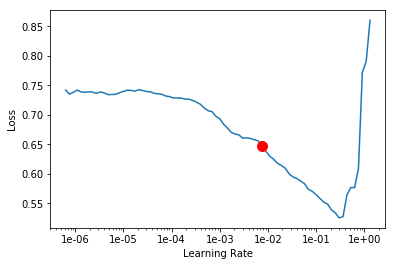

In [28]:
learn.recorder.plot(suggestion=True)

In [29]:
learn.fit_one_cycle(1, 7e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.293960,0.213192,0.912478,00:07


In [30]:
learn.save('first')

In [31]:
learn.load('first');

In [32]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(3.5e-3/(2.6**4),3.5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.300225,0.179282,0.935875,00:08


In [33]:
learn.save('second')

In [34]:
learn.load('second');

In [35]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(1.75e-3/(2.6**4),1.75e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.249591,0.182007,0.926343,00:13


In [36]:
learn.save('third')

In [37]:
learn.load('third');

In [38]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(3.5e-4/(2.6**4),3.5e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.213421,0.167566,0.935009,00:19
1,0.192692,0.164303,0.934142,00:19


In [39]:
learn.predict("Awful flight")

(Category negative, tensor(0), tensor([0.8188, 0.1812]))

In [40]:
learn.predict("Great trip, thanks to all")

(Category positive, tensor(1), tensor([0.0126, 0.9874]))

In [41]:
learn.predict("attendant was rude!")

(Category positive, tensor(1), tensor([0.2476, 0.7524]))

In [42]:
learn.predict("I thought I was going to have some great vacations, but everything was ruined by the delay and the rude service. Way, to go @VirginAmerica!")

(Category negative, tensor(0), tensor([0.7906, 0.2094]))

In [43]:
learn.predict("My first time with you guys, pretty fair. Food was memorable :-)")

(Category positive, tensor(1), tensor([0.2735, 0.7265]))